<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\e'
/var/folders/3k/vkjymcf10tl2s2m0h7svv1h00000gn/T/ipykernel_63918/3678212800.py:75: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$ (log scale)')
/var/folders/3k/vkjymcf10tl2s2m0h7svv1h00000gn/T/ipykernel_63918/3678212800.py:85: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$ (log scale)')
100%|██████████| 20/20 [00:00<00:00, 466.50it/s]
/var/folders/3k/vkjymcf10tl2s2m0h7svv1h00000gn/T/ipykernel_63918/3678212800.py:69: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  

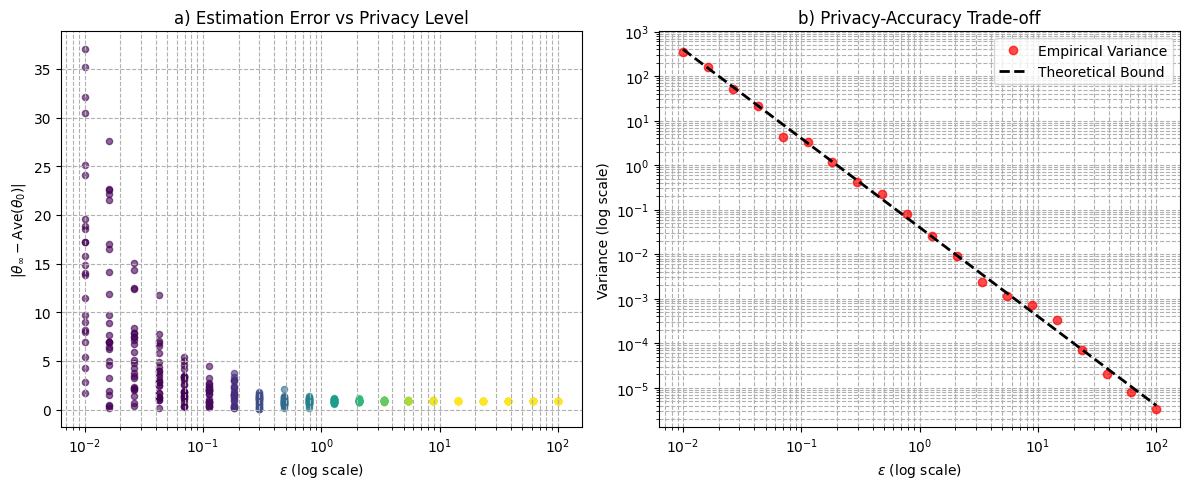

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# params
np.random.seed(616)  
n = 50               # 代理数量
delta = 1.0          # 相邻状态差异上限
true_avg = 50.0      # 真实平均值（固定值方便可视化）
num_epsilons = 20    # ε采样点数
num_runs = 25        # 每个ε的仿真次数
max_iter = 1000      # 最大迭代次数
tol = 1e-2           # 收敛阈值

epsilons = np.logspace(-2, 2, num_epsilons)

# 生成图结构
def generate_network(n_nodes=50, p=0.1):
    A = np.ones((n_nodes, n_nodes))
    A = A * (np.random.binomial(1, p, (n_nodes, n_nodes)) + np.random.binomial(1, p, (n_nodes, n_nodes)))
    A = (A + A.T) / 2
    np.fill_diagonal(A, 0)
    D = np.diag(A.sum(axis=1))
    L = D - A
    return L

L = generate_network(n)
h = 0.99 / np.max(np.diag(L))  # 稳定步长

def one_shot_consensus(theta0, L, epsilon, max_iter=1000):
    """s=1, q=0的单次扰动算法"""
    n = len(theta0)
    c = delta / epsilon  # 理论最优参数
    
    eta0 = np.random.laplace(scale=c, size=n)
    theta = theta0.copy() + eta0
    A = np.eye(n) - h * L
    
    for _ in range(max_iter):
        new_theta = A @ theta
        if np.linalg.norm(new_theta - theta) < tol:
            break
        theta = new_theta
    
    return theta.mean()  # 返回最终平均值


errors = []
variances = []
theoretical_var = []

theta0 = np.random.normal(50, 10, n)  # 均值为50，标准差10

for eps in tqdm(epsilons):
    final_avgs = []
    for _ in range(num_runs):
        final_avg = one_shot_consensus(theta0, L, epsilon=eps, max_iter=max_iter)
        final_avgs.append(final_avg)

    errors.extend([abs(avg - true_avg) for avg in final_avgs])
    variances.append(np.var(final_avgs))
    theoretical_var.append(2 * delta**2 / (n * eps**2))  # 理论公式


plt.figure(figsize=(12, 5))

plt.subplot(121)
for i, eps in enumerate(epsilons):
    plt.scatter([eps]*num_runs, 
                np.array(errors[i*num_runs : (i+1)*num_runs]), 
                s=20, alpha=0.6,
                c=plt.cm.viridis(np.log10(eps)/2 + 0.5))
    
plt.xscale('log')
plt.xlabel('$\epsilon$ (log scale)')
plt.ylabel('$|\\theta_{\\infty} - \\mathrm{Ave}(\\theta_0)$|')
plt.title('a) Estimation Error vs Privacy Level')
plt.grid(True, which='both', linestyle='--')

plt.subplot(122)
plt.plot(epsilons, variances, 'ro', label='Empirical Variance', alpha=0.7)
plt.plot(epsilons, theoretical_var, 'k--', lw=2, label='Theoretical Bound')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\epsilon$ (log scale)')
plt.ylabel('Variance (log scale)')
plt.title('b) Privacy-Accuracy Trade-off')
plt.legend()
plt.grid(True, which='both', linestyle='--')

plt.tight_layout()
plt.show()